In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load data
train_data = pd.read_csv('train.csv', parse_dates=['Date'], index_col='Date')
test_data = pd.read_csv('test.csv', parse_dates=['Date'], index_col='Date')
data = pd.concat([train_data, test_data], axis=0)
# Parameters
N = 1  # predict N days ahead
lags = 50  # use past lags days

feature_cols = ['Close', 'Turnover', 'High', 'Low', 'Transaction', 'Movement', 'NASDAQ']

lagged_data = {}
for col in feature_cols:
    for lag in range(1, lags + 1):
        lagged_data[f'{col}_lag{lag}'] = data[col].shift(lag)

lagged_df = pd.DataFrame(lagged_data, index=data.index)

target = data['Movement'].shift(-N)

# Combine features and target
combined = pd.concat([lagged_df, target.rename('Future_Movement')], axis=1)
combined = combined.dropna()  # remove NaNs

# Split based on date
train_data = combined[combined.index < '2025-01-01']
test_data = combined[combined.index >= '2025-01-01']

X_train = train_data.drop(columns='Future_Movement')
y_train = train_data['Future_Movement']

X_test = test_data.drop(columns='Future_Movement')
y_test = test_data['Future_Movement']

# Train XGBClassifier
model = XGBClassifier(
    objective='binary:logistic', 
    base_score=0.1,
    n_estimators=100000,
    learning_rate=0.2,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=0
)
model.fit(X_train, y_train)

C:\Users\user\anaconda3\envs\NLPLab1\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:33:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,0.1
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [8]:
y_pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Results")
print("-" * 40)

future_index = y_test.index + pd.Timedelta(days=N)

pred_df = pd.DataFrame({
    'True': y_test.values,
    'Pred': y_pred
}, index=future_index)

print(pred_df.head(15))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.4f}\n')

# Detailed Classification Report (Precision, Recall, F1-Score)
print('Classification Report:')
print(classification_report(y_test, y_pred))
pred_df.to_csv("XGBoost_prediction_2025_T+1.csv", index=False)

XGBoost Classification Results
----------------------------------------
            True  Pred
Date                  
2025-01-03   1.0     0
2025-01-04   1.0     0
2025-01-07   1.0     1
2025-01-08   0.0     0
2025-01-09   0.0     1
2025-01-10   1.0     1
2025-01-11   0.0     0
2025-01-14   1.0     1
2025-01-15   0.0     1
2025-01-16   1.0     1
2025-01-17   1.0     1
2025-01-18   1.0     0
2025-01-21   1.0     0
2025-01-22   1.0     1
2025-01-23   0.0     1
Accuracy Score: 0.5854

Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.42      0.45        84
         1.0       0.63      0.70      0.67       121

    accuracy                           0.59       205
   macro avg       0.56      0.56      0.56       205
weighted avg       0.58      0.59      0.58       205



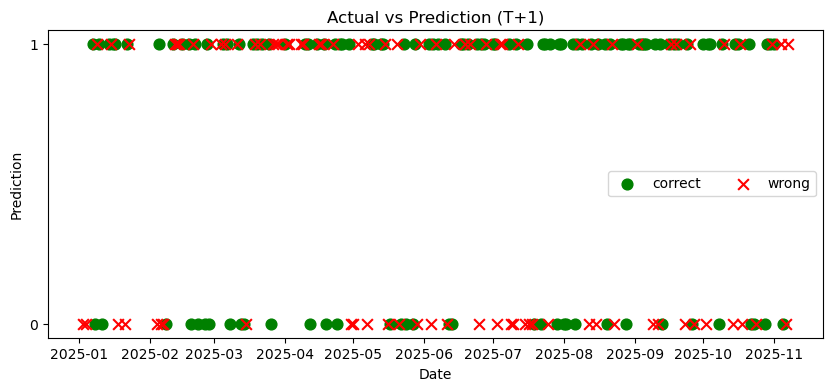

In [9]:
correct = pred_df["True"] == pred_df["Pred"]
wrong = ~correct

plt.figure(figsize=(10,4))
plt.scatter(pred_df.index[correct],
            pred_df.loc[correct, "Pred"],
            marker="o", s=60, color="green", label="correct")
plt.scatter(pred_df.index[wrong],
            pred_df.loc[wrong, "Pred"],
            marker="x", s=60, color="red", label="wrong")
plt.yticks([0,1])
plt.xlabel("Date")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction (T+1)")
plt.legend(ncol=2)
plt.show()


In [2]:
# Load data
train_data = pd.read_csv('train.csv', parse_dates=['Date'], index_col='Date')
test_data = pd.read_csv('test.csv', parse_dates=['Date'], index_col='Date')
data = pd.concat([train_data, test_data], axis=0)
# Parameters
N = 5  # predict N days ahead
lags = 50  # use past lags days

feature_cols = ['Close', 'Turnover', 'High', 'Low', 'Transaction', 'Movement']

lagged_data = {}
for col in feature_cols:
    for lag in range(1, lags + 1):
        lagged_data[f'{col}_lag{lag}'] = data[col].shift(lag)

lagged_df = pd.DataFrame(lagged_data, index=data.index)

target = data['Movement'].shift(-N)

# Combine features and target
combined = pd.concat([lagged_df, target.rename('Future_Movement')], axis=1)
combined = combined.dropna()  # remove NaNs

# Split based on date
train_data = combined[combined.index < '2025-01-01']
test_data = combined[combined.index >= '2025-01-01']

X_train = train_data.drop(columns='Future_Movement')
y_train = train_data['Future_Movement']

X_test = test_data.drop(columns='Future_Movement')
y_test = test_data['Future_Movement']

# Train XGBClassifier
model = XGBClassifier(
    objective='binary:logistic', 
    base_score=0.1,
    n_estimators=100000,
    learning_rate=0.2,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=0
)
model.fit(X_train, y_train)

C:\Users\user\anaconda3\envs\NLPLab1\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:22:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,0.1
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [5]:
y_pred = model.predict(X_test)

print("XGBoost Classification Results")
print("-" * 40)

future_index = y_test.index + pd.Timedelta(days=N)

pred_df = pd.DataFrame({
    'True': y_test.values,
    'Pred': y_pred
}, index=future_index)

print(pred_df.head(15))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.4f}\n')

# Detailed Classification Report (Precision, Recall, F1-Score)
print('Classification Report:')
print(classification_report(y_test, y_pred))
pred_df.to_csv("XGBoost_prediction_2025_T+5.csv", index=False)

XGBoost Classification Results
----------------------------------------
            True  Pred
Date                  
2025-01-07   0.0     1
2025-01-08   1.0     1
2025-01-11   0.0     0
2025-01-12   1.0     1
2025-01-13   0.0     0
2025-01-14   1.0     1
2025-01-15   1.0     0
2025-01-18   1.0     1
2025-01-19   1.0     1
2025-01-20   1.0     1
2025-01-21   0.0     1
2025-01-22   1.0     0
2025-01-25   1.0     1
2025-01-26   1.0     0
2025-01-27   1.0     1
Accuracy Score: 0.6070

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.39      0.45        83
         1.0       0.64      0.76      0.69       118

    accuracy                           0.61       201
   macro avg       0.59      0.57      0.57       201
weighted avg       0.59      0.61      0.59       201



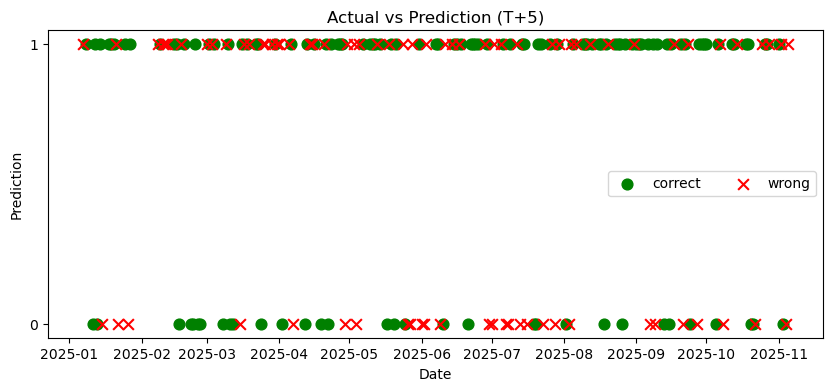

In [4]:
correct = pred_df["True"] == pred_df["Pred"]
wrong = ~correct

plt.figure(figsize=(10,4))
plt.scatter(pred_df.index[correct],
            pred_df.loc[correct, "Pred"],
            marker="o", s=60, color="green", label="correct")
plt.scatter(pred_df.index[wrong],
            pred_df.loc[wrong, "Pred"],
            marker="x", s=60, color="red", label="wrong")
plt.yticks([0,1])
plt.xlabel("Date")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction (T+5)")
plt.legend(ncol=2)
plt.show()


In [ ]:
df = pd.read_csv('df.csv', parse_dates=['Date'])
df = df.sort_values('Date')

N = 1        # predict next day
lags = 1    # use yesterday

feature_cols = ['Close', 'Turnover', 'High', 'Low', 'Transaction', 'Movement', 'NASDAQ']

# Create lagged features
lagged_features = {}
for col in feature_cols:
    for lag in range(1, lags + 1):
        lagged_features[f'{col}_lag{lag}'] = df[col].shift(lag)
lagged_df = pd.DataFrame(lagged_features, index=df.index)

target = df['Movement'].shift(-N)

# Combine Date, features, target
combined = pd.concat([df['Date'], lagged_df, target.rename('Target')], axis=1)
combined = combined.dropna()  

predictions_all = []

years_to_predict = range(2020, 2026)
last_date = combined['Date'].max()

for year in years_to_predict:

    train_start = 2010
    train_end = year - 1

    # Training: previous 10 years
    train_mask = (combined['Date'].dt.year >= train_start) & (combined['Date'].dt.year <= train_end)
    test_mask = (combined['Date'].dt.year == year) & (combined['Date'] <= last_date)

    train_df = combined.loc[train_mask]
    test_df  = combined.loc[test_mask]

    if len(train_df) < 200 or len(test_df) < 1:
        print(f"Skipping year {year} due to insufficient data.")
        continue

    X_train = train_df.drop(['Date', 'Target'], axis=1)
    y_train = train_df['Target']

    X_test = test_df.drop(['Date', 'Target'], axis=1)
    y_test = test_df['Target']

    # Train XGBoost
    model = XGBClassifier(
        objective='binary:logistic',
        base_score=0.1,
        n_estimators=10000,
        learning_rate=0.1,
        max_depth=2,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=0
    )

    model.fit(X_train, y_train)

    # Predict probability of rise
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n====== YEAR {year} ======")
    print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))

    # Save only Date and probability
    year_result = pd.DataFrame({
        'Date': test_df['Date'],
        'Predict': y_prob
    })

    predictions_all.append(year_result)


predictions_all = pd.concat(predictions_all)
predictions_all.to_csv("XGBoost_prediction_2020-25.csv", index=False)
print("\nSaved to XGBoost_prediction_2020-25.csv")